In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as NN
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [47]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [48]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [60]:
train_data = datasets.ImageFolder(
    root="C:\\Users\\VICTUS\Documents\\Data-Science\\.git\\Cat_Dog_data\\train\\",
    transform=train_transform
)

test_data = datasets.ImageFolder(
    root="C:\\Users\VICTUS\\Documents\\Data-Science\\.git\\Cat_Dog_data\\test\\",
    transform=test_transform
)

valid_data = datasets.ImageFolder(
    root="C:\\Users\VICTUS\\Documents\\Data-Science\\.git\\Cat_Dog_data\\validation\\",
    transform=test_transform
)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num cv images: ', len(valid_data))

Num training images:  22500
Num test images:  100
Num cv images:  2400


In [50]:
batch_size = 32
# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders_scratch = {
    'train': train_dataloader,
    'test' : test_dataloader,
    'valid': valid_dataloader
}

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 128, 128])
Shape of y: torch.Size([32]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

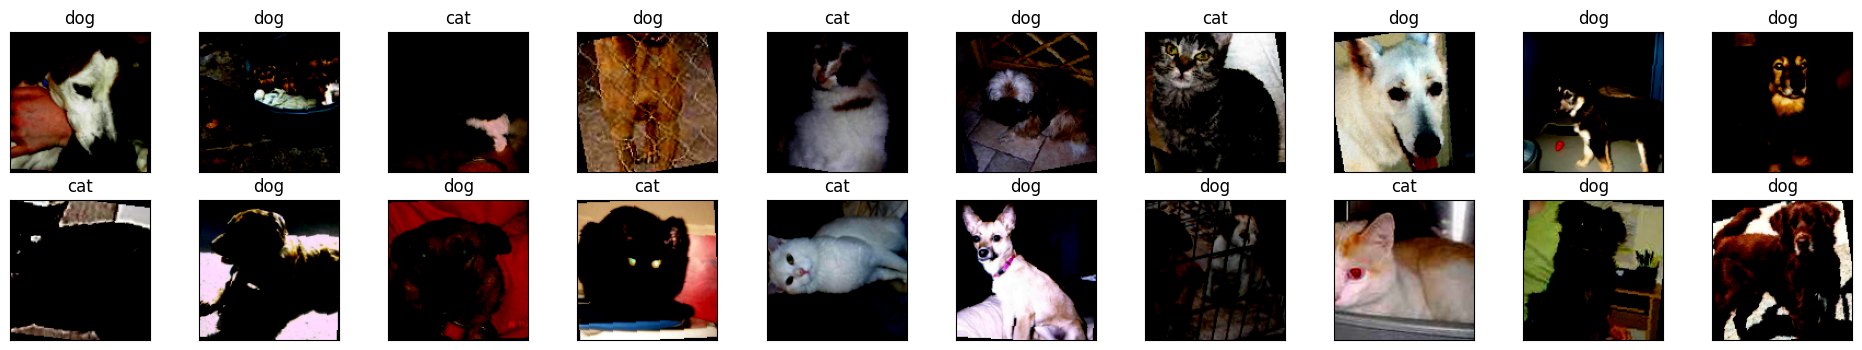

In [51]:
classes = ['cat','dog']
# visualize image
def imshow(img):
    plt.imshow(np.transpose(img,(1,2,0)))

# Obtain one batch of image
dataiter = iter(train_dataloader)
images, labels = dataiter.__next__()
images = images.numpy()

#plot the images in the batch

fig = plt.figure(figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [52]:
def conv_layer(in_channels, out_channels, kernel_size=4):
    layers = []
    layers.append(NN.ReLU())
    conv_layer = NN.Conv2d(in_channels, out_channels, kernel_size)
    layers.append(conv_layer)
    layers.append(NN.MaxPool2d(2, 2,ceil_mode=True))
    layers.append(NN.BatchNorm2d(out_channels))
    return NN.Sequential(*layers)

In [53]:
# CNN Architecture

class CnnNet(NN.Module):
    def __init__(self):
        super().__init__()
        self.conv = NN.Sequential(
                # 3 * 128 * 128
                conv_layer(3, 16),
                # 16 * 64 * 64
                conv_layer(16, 32),
                # 32 * 32 *32
                conv_layer(32, 64),
                # 64 * 16 * 16
                conv_layer(64, 128),
                # 128 * 8 * 8
                conv_layer(128, 256)
                # 256 * 4 * 4
        )
        self.linear = NN.Linear(2*2*256, 2)
        self.dropout = NN.Dropout(0.2)

    def forward(self, X):
        conv_output = self.conv(X)
        linear_input = self.dropout(conv_output.view(-1, 2*2*256))
        return self.linear(linear_input)

model = CnnNet()

if train_on_gpu:
    model.cuda()

model      

CnnNet(
  (conv): Sequential(
    (0): Sequential(
      (0): ReLU()
      (1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ReLU()
      (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ReLU()
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(ker

In [54]:
criterion = NN.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
torch.cuda.empty_cache()

In [56]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min=np.Inf):
    """returns trained model"""
    print('started train')    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss_min > valid_loss:
            valid_loss_min = valid_loss
            print('Validation loss decreased saving model.....')
            torch.save(model.state_dict(), save_path)

    # return trained model
    return model


model_scratch = train(10, loaders_scratch, model, optimizer, 
                      criterion, train_on_gpu, 'model_scratch.pt')

started train
Epoch: 1 	Training Loss: 0.598344 	Validation Loss: 0.201535
Validation loss decreased saving model.....
Epoch: 2 	Training Loss: 0.475747 	Validation Loss: 0.164049
Validation loss decreased saving model.....
Epoch: 3 	Training Loss: 0.413731 	Validation Loss: 0.215748
Epoch: 4 	Training Loss: 0.370843 	Validation Loss: 0.399378
Epoch: 5 	Training Loss: 0.336910 	Validation Loss: 0.431370
Epoch: 6 	Training Loss: 0.317009 	Validation Loss: 0.179332
Epoch: 7 	Training Loss: 0.297356 	Validation Loss: 0.092443
Validation loss decreased saving model.....
Epoch: 8 	Training Loss: 0.278721 	Validation Loss: 0.240646
Epoch: 9 	Training Loss: 0.268045 	Validation Loss: 0.054229
Validation loss decreased saving model.....
Epoch: 10 	Training Loss: 0.253590 	Validation Loss: 0.294247


In [57]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'
print(f"Map Loc: {map_location}")
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=map_location))
model_scratch

Map Loc: <function <lambda> at 0x000001DDF88BD8B0>


CnnNet(
  (conv): Sequential(
    (0): Sequential(
      (0): ReLU()
      (1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ReLU()
      (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ReLU()
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(ker

In [58]:
def test(loaders, model, criterion, use_cuda):
    print('started testing')
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)  
        if batch_idx%10==0:
            print('Batch {} Test Loss: {:.6f}\n'.format(batch_idx,test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model, criterion, train_on_gpu)

started testing
Batch 0 Test Loss: 0.384974


Test Accuracy: 88% (88/100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

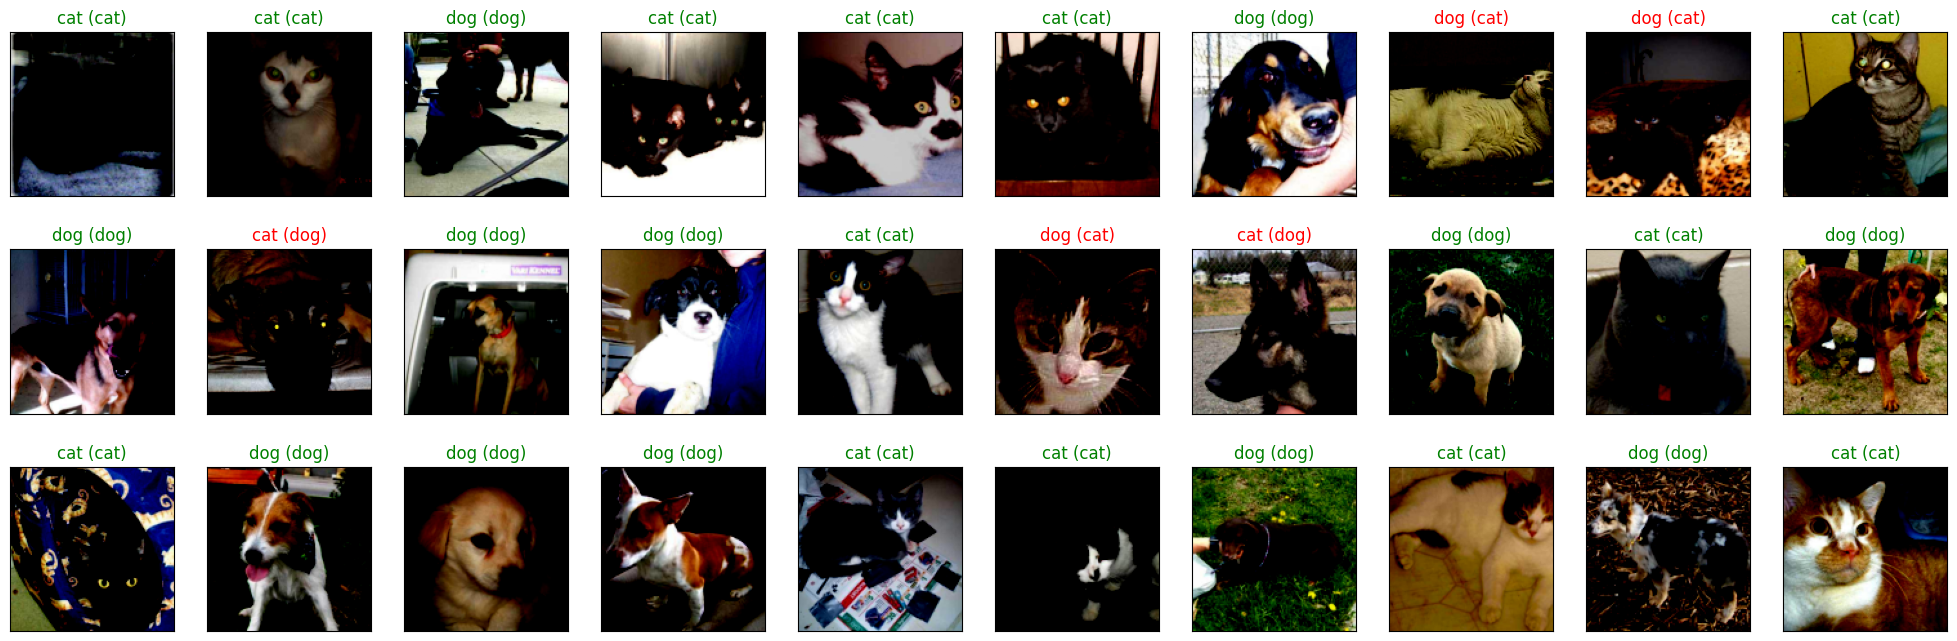

In [59]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.__next__()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(30):
    ax = fig.add_subplot(3, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))